In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 101

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [3]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10('./data/', download=True, transform=transform, train=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [0]:
#for i in range(len(dataset)): # or i, image in enumerate(dataset)
#    images, labels = dataset[i] # or whatever your dataset returns

In [5]:
for images, labels in data_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [0]:
#img, lb = [[imgs, labl] for imgs, labl in dataset]

In [0]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [0]:
inputs, classes = next(iter(data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

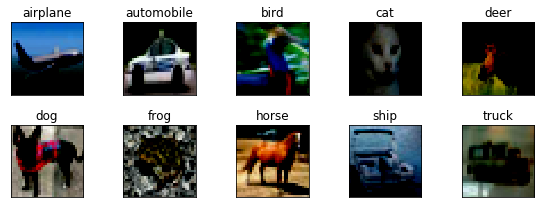

In [9]:
num_classes = len(np.unique(classes))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    #print(i)
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(classes[:]==i)[0]
    features_idx = inputs[idx,::]
    #print(features_idx.shape[0])
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(np.transpose(img, (1,2,0)))
    
plt.tight_layout()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_embeddings = nn.Embedding(10, 10)

        self.fc = nn.Sequential(
            # FC layer: 2 x 2 x 512
            nn.Linear(110, 2*2*512),
            nn.BatchNorm1d(2*2*512),
            nn.LeakyReLU(True)
        )
        
        self.model = nn.Sequential(
            # state size. (ngf*8) x 2 x 2
            # to use only ReLU for Generator model
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                   m.bias.data.zero_()
    
    def forward(self, z, b_size, labels):
        z = z.view(z.size(0), 100)
        #c = self.label_embeddings(labels)
        #print(z.shape)
        z = torch.cat((z.float(), labels.float()), -1)
        x = self.fc(z)
        x = x.view(b_size, 512, 2, 2)
        out = self.model(x)
        #img = img.view(img.size(0), *img_shape)  
        return out #.view(b_size, 3, 32, 32)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(  
            # state size. (nc) x 32 x 32

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), #64 x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2

            nn.Flatten()
            # state size. 2*2*512
        )
      
        self.fc = nn.Sequential(
            nn.Linear(2*2*512 + 10, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
            nn.Sigmoid()
            # state size. 1
        )         

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x, labels=None):
        #x = x.view(x.size(0), 3072)
        #c = self.label_emb(labels)
        out = self.model(x)
        out = torch.cat((out, labels.float()), -1)
        out = self.fc(out)
        return out.squeeze()

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in generator.state_dict():
    print(param_tensor, "\t", generator.state_dict()[param_tensor].size())
print("--------------------------------------------------------------------------------------")
print("Discriminator's state_dict:")
for param_tensor in discriminator.state_dict():
    print(param_tensor, "\t", discriminator.state_dict()[param_tensor].size())
print("--------------------------------------------------------------------------------------")
# Print optimizer's state_dict
print("Generator Optimizer's state_dict:")
for var_name in g_optimizer.state_dict():
    print(var_name, "\t", g_optimizer.state_dict()[var_name])
print("--------------------------------------------------------------------------------------")
print("Discriminator Optimizer's state_dict:")
for var_name in d_optimizer.state_dict():
    print(var_name, "\t", d_optimizer.state_dict()[var_name])

Generator's state_dict:
fc.0.weight 	 torch.Size([2048, 110])
fc.0.bias 	 torch.Size([2048])
fc.1.weight 	 torch.Size([2048])
fc.1.bias 	 torch.Size([2048])
fc.1.running_mean 	 torch.Size([2048])
fc.1.running_var 	 torch.Size([2048])
fc.1.num_batches_tracked 	 torch.Size([])
model.0.weight 	 torch.Size([512, 256, 4, 4])
model.1.weight 	 torch.Size([256])
model.1.bias 	 torch.Size([256])
model.1.running_mean 	 torch.Size([256])
model.1.running_var 	 torch.Size([256])
model.1.num_batches_tracked 	 torch.Size([])
model.3.weight 	 torch.Size([256, 128, 4, 4])
model.4.weight 	 torch.Size([128])
model.4.bias 	 torch.Size([128])
model.4.running_mean 	 torch.Size([128])
model.4.running_var 	 torch.Size([128])
model.4.num_batches_tracked 	 torch.Size([])
model.6.weight 	 torch.Size([128, 64, 4, 4])
model.7.weight 	 torch.Size([64])
model.7.bias 	 torch.Size([64])
model.7.running_mean 	 torch.Size([64])
model.7.running_var 	 torch.Size([64])
model.7.num_batches_tracked 	 torch.Size([])
model.9.w

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, fake_labels):
    g_optimizer.zero_grad()
    z = Variable(torch.FloatTensor(torch.randn(batch_size, nz, 1, 1))).cuda()
    fake_images = generator(z, batch_size, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    #Use for loop to replace step()
    #Or come up with a function to avoid discriminator being trained as well
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, real_labels, fake_labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, real_labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size) * 0.9).cuda())
    # train with fake images
    z = Variable(torch.FloatTensor(torch.randn(batch_size, nz, 1, 1))).cuda() # can change randn(64, 100, 1, 1) to have randn(64, 100)
    fake_images = generator(z, batch_size, fake_labels)
    fake_validity = discriminator(fake_images.detach(), fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = (real_loss + fake_loss) * 0.5
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

epoch = 1/101, d_loss=0.738, g_loss=0.753                                                                                                     


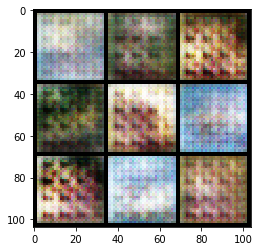

epoch = 2/101, d_loss=0.770, g_loss=1.565                                                                                                     


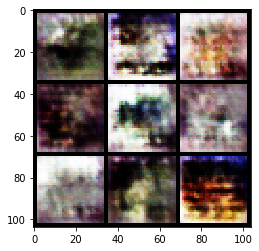

epoch = 3/101, d_loss=0.572, g_loss=0.761                                                                                                     


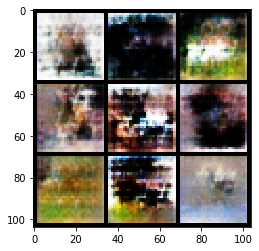

epoch = 4/101, d_loss=0.579, g_loss=0.989                                                                                                     


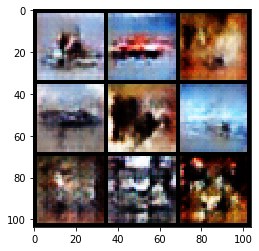

epoch = 5/101, d_loss=0.675, g_loss=2.293                                                                                                     


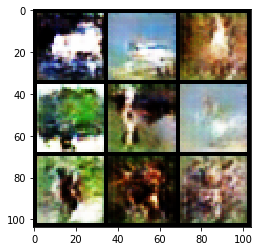

epoch = 6/101, d_loss=0.557, g_loss=1.487                                                                                                     


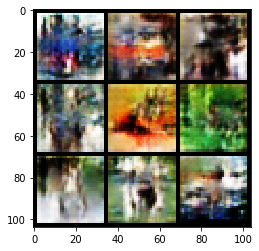

epoch = 7/101, d_loss=0.354, g_loss=0.835                                                                                                     


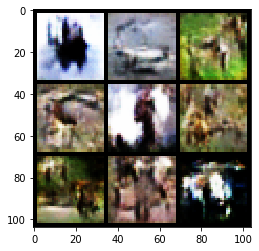

epoch = 8/101, d_loss=0.316, g_loss=2.274                                                                                                     


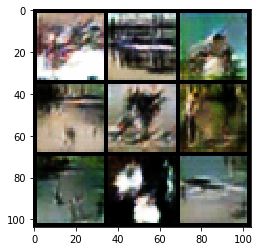

epoch = 9/101, d_loss=0.696, g_loss=0.671                                                                                                     


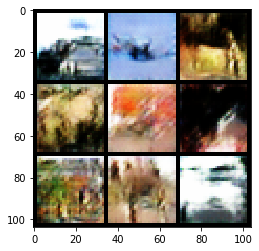

epoch = 10/101, d_loss=0.600, g_loss=2.017                                                                                                     


epoch = 11/101, d_loss=0.433, g_loss=3.457                                                                                                     


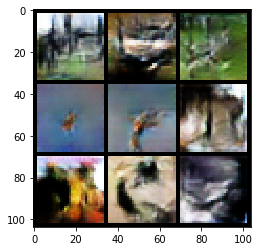

epoch = 12/101, d_loss=0.614, g_loss=2.018                                                                                                     


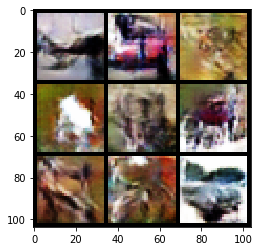

epoch = 13/101, d_loss=0.209, g_loss=3.670                                                                                                     


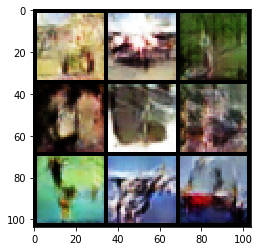

epoch = 14/101, d_loss=0.493, g_loss=3.203                                                                                                     


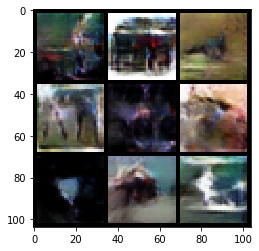

epoch = 15/101, d_loss=1.024, g_loss=1.259                                                                                                     


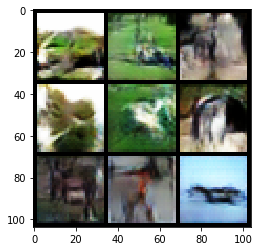

epoch = 16/101, d_loss=0.543, g_loss=3.614                                                                                                     


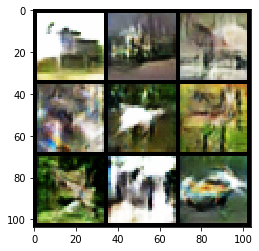

epoch = 17/101, d_loss=1.034, g_loss=1.649                                                                                                     


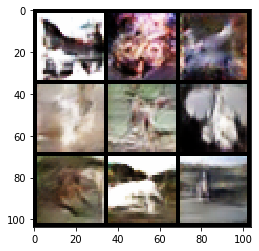

epoch = 18/101, d_loss=0.527, g_loss=5.069                                                                                                     


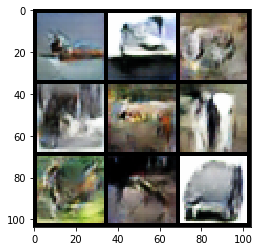

epoch = 19/101, d_loss=0.676, g_loss=2.315                                                                                                     


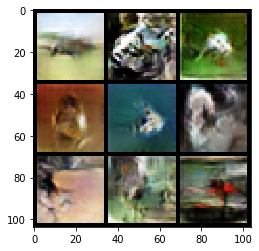

epoch = 20/101, d_loss=0.895, g_loss=4.184                                                                                                     


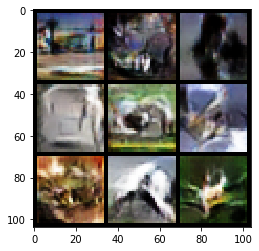

epoch = 21/101, d_loss=0.487, g_loss=1.020                                                                                                     


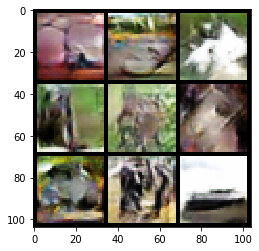

epoch = 22/101, d_loss=0.390, g_loss=1.093                                                                                                     


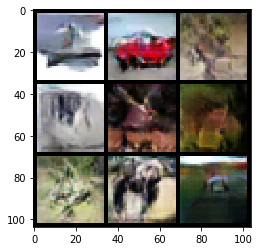

epoch = 23/101, d_loss=0.589, g_loss=1.064                                                                                                     


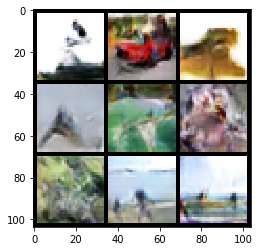

epoch = 24/101, d_loss=1.825, g_loss=0.304                                                                                                     


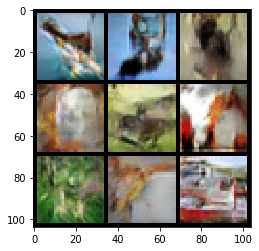

epoch = 25/101, d_loss=0.512, g_loss=1.694                                                                                                     


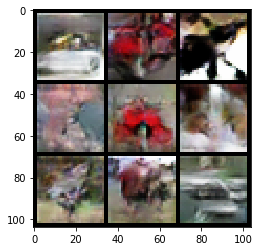

epoch = 26/101, d_loss=0.216, g_loss=4.255                                                                                                     


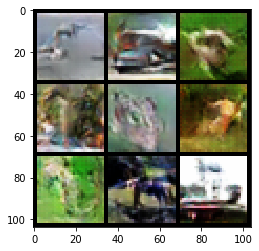

epoch = 27/101, d_loss=0.280, g_loss=2.423                                                                                                     


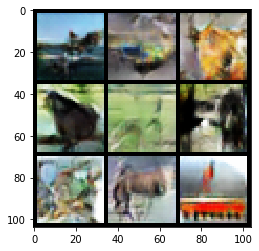

epoch = 28/101, d_loss=0.322, g_loss=3.921                                                                                                     


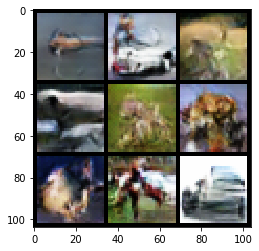

epoch = 29/101, d_loss=0.416, g_loss=0.731                                                                                                     


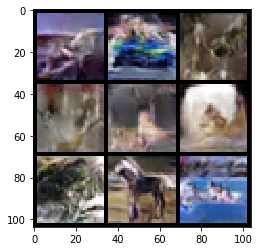

epoch = 30/101, d_loss=0.547, g_loss=0.106                                                                                                     


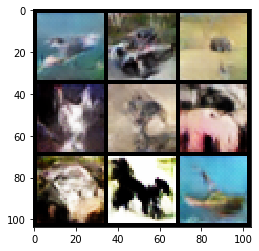

epoch = 31/101, d_loss=0.316, g_loss=5.961                                                                                                     


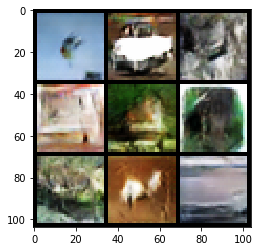

epoch = 32/101, d_loss=0.518, g_loss=3.110                                                                                                     


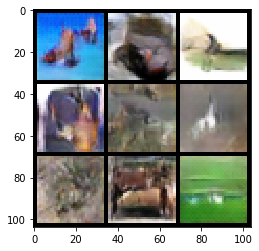

epoch = 33/101, d_loss=0.205, g_loss=2.410                                                                                                     


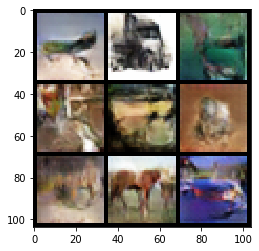

epoch = 34/101, d_loss=0.318, g_loss=4.945                                                                                                     


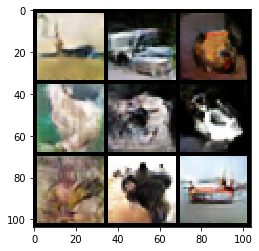

epoch = 35/101, d_loss=0.323, g_loss=4.060                                                                                                     


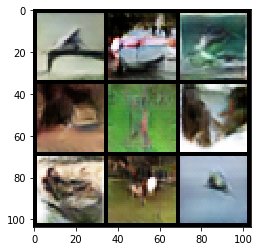

epoch = 36/101, d_loss=0.980, g_loss=3.693                                                                                                     


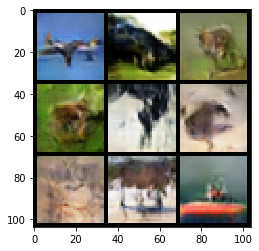

epoch = 37/101, d_loss=0.243, g_loss=6.078                                                                                                     


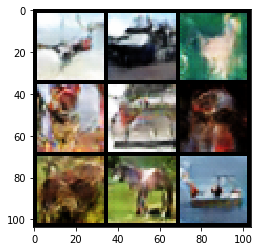

epoch = 38/101, d_loss=0.346, g_loss=2.173                                                                                                     


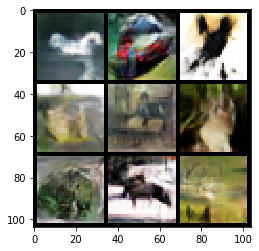

epoch = 39/101, d_loss=0.601, g_loss=5.191                                                                                                     


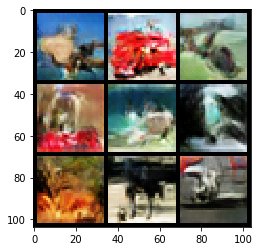

epoch = 40/101, d_loss=0.245, g_loss=4.611                                                                                                     


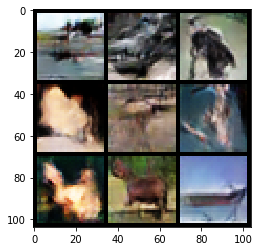

epoch = 41/101, d_loss=0.274, g_loss=3.316                                                                                                     


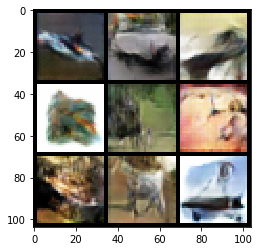

epoch = 42/101, d_loss=0.387, g_loss=1.554                                                                                                     


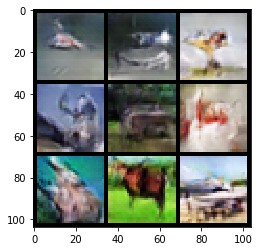

epoch = 43/101, d_loss=0.307, g_loss=3.713                                                                                                     


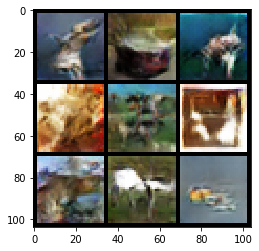

epoch = 44/101, d_loss=0.554, g_loss=2.665                                                                                                     


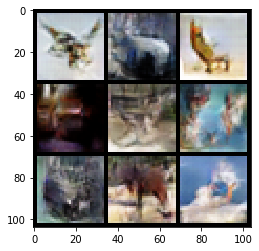

epoch = 45/101, d_loss=1.094, g_loss=0.123                                                                                                     


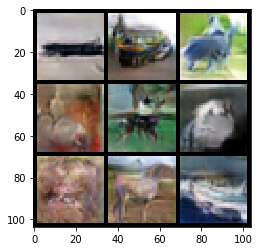

epoch = 46/101, d_loss=0.255, g_loss=4.030                                                                                                     


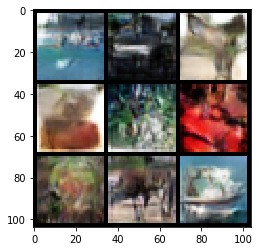

epoch = 47/101, d_loss=0.216, g_loss=7.413                                                                                                     


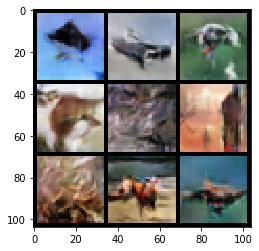

epoch = 48/101, d_loss=0.526, g_loss=3.381                                                                                                     


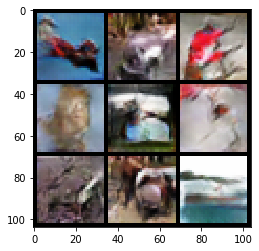

epoch = 49/101, d_loss=0.478, g_loss=1.914                                                                                                     


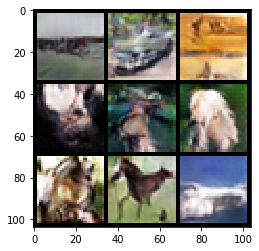

epoch = 50/101, d_loss=0.197, g_loss=6.174                                                                                                     


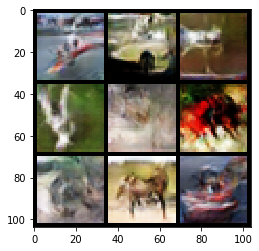

epoch = 51/101, d_loss=0.455, g_loss=2.207                                                                                                     


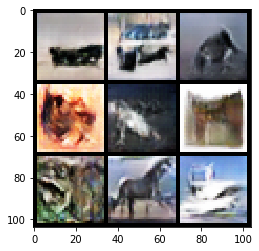

epoch = 52/101, d_loss=0.383, g_loss=8.183                                                                                                     


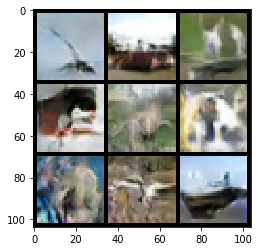

epoch = 53/101, d_loss=0.271, g_loss=5.550                                                                                                     


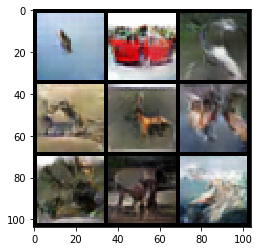

epoch = 54/101, d_loss=0.216, g_loss=3.418                                                                                                     


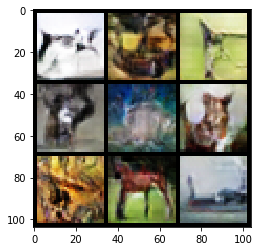

epoch = 55/101, d_loss=1.037, g_loss=0.927                                                                                                     


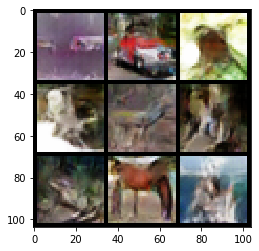

epoch = 56/101, d_loss=0.300, g_loss=4.719                                                                                                     


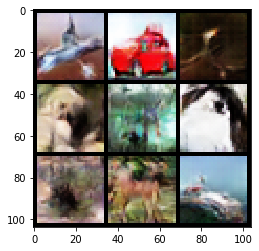

epoch = 57/101, d_loss=0.183, g_loss=7.043                                                                                                     


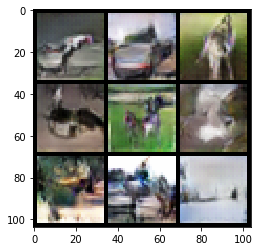

epoch = 58/101, d_loss=0.974, g_loss=0.910                                                                                                     


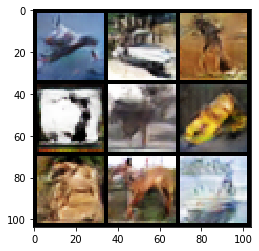

epoch = 59/101, d_loss=0.295, g_loss=4.821                                                                                                     


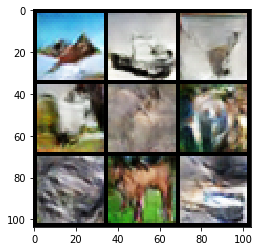

epoch = 60/101, d_loss=0.213, g_loss=4.891                                                                                                     


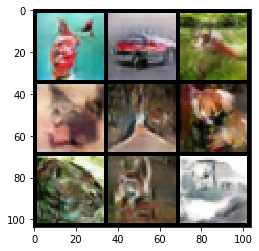

epoch = 61/101, d_loss=0.278, g_loss=6.652                                                                                                     


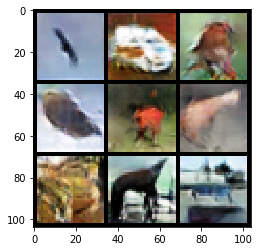

epoch = 62/101, d_loss=0.368, g_loss=2.990                                                                                                     


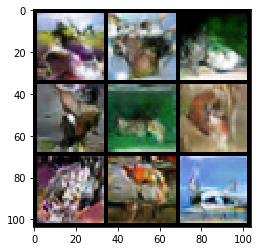

epoch = 63/101, d_loss=0.185, g_loss=8.364                                                                                                     


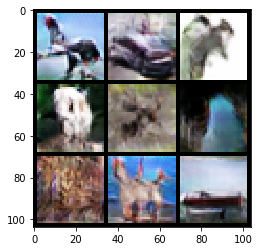

epoch = 64/101, d_loss=0.316, g_loss=0.751                                                                                                     


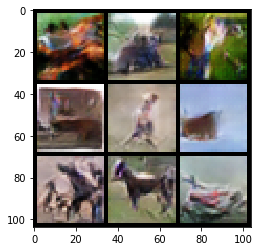

epoch = 65/101, d_loss=0.370, g_loss=0.919                                                                                                     


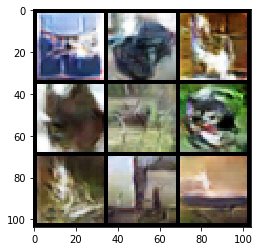

epoch = 66/101, d_loss=0.412, g_loss=0.734                                                                                                     


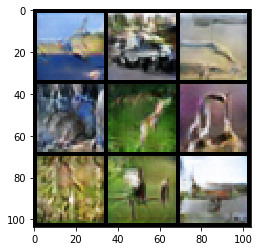

epoch = 67/101, d_loss=0.199, g_loss=4.577                                                                                                     


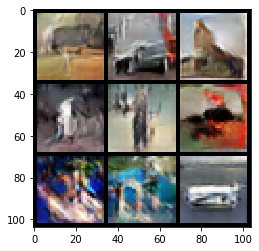

epoch = 68/101, d_loss=0.204, g_loss=4.749                                                                                                     


epoch = 69/101, d_loss=0.178, g_loss=3.189                                                                                                     


epoch = 70/101, d_loss=0.305, g_loss=4.877                                                                                                     


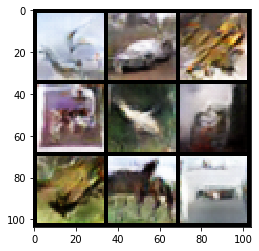

epoch = 71/101, d_loss=0.894, g_loss=1.247                                                                                                     


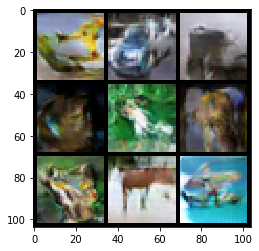

epoch = 72/101, d_loss=0.365, g_loss=3.073                                                                                                     


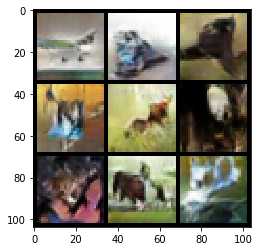

epoch = 73/101, d_loss=0.608, g_loss=1.452                                                                                                     


epoch = 74/101, d_loss=0.289, g_loss=4.249                                                                                                     


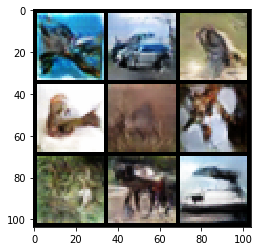

epoch = 75/101, d_loss=0.190, g_loss=5.600                                                                                                     


epoch = 76/101, d_loss=0.538, g_loss=2.474                                                                                                     


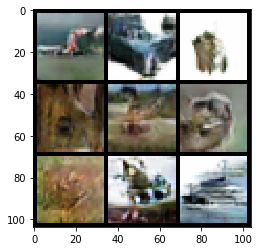

epoch = 77/101, d_loss=0.244, g_loss=2.362                                                                                                     


epoch = 78/101, d_loss=0.237, g_loss=6.970                                                                                                     


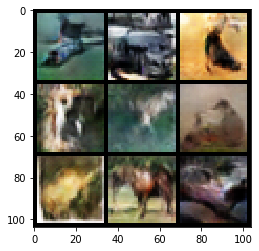

epoch = 79/101, d_loss=0.279, g_loss=5.098                                                                                                     


epoch = 80/101, d_loss=0.289, g_loss=3.783                                                                                                     


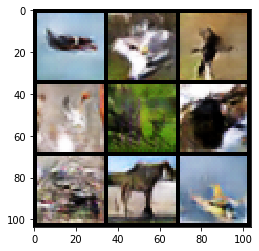

epoch = 81/101, d_loss=0.420, g_loss=3.467                                                                                                     


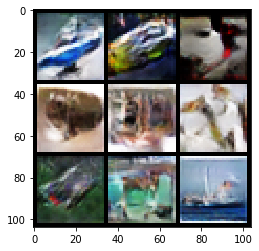

epoch = 82/101, d_loss=0.653, g_loss=4.284                                                                                                     


epoch = 83/101, d_loss=0.774, g_loss=0.417                                                                                                     


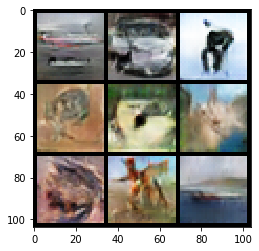

epoch = 84/101, d_loss=0.179, g_loss=9.905                                                                                                     


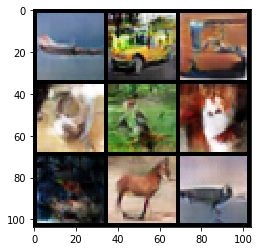

epoch = 85/101, d_loss=1.406, g_loss=0.535                                                                                                     


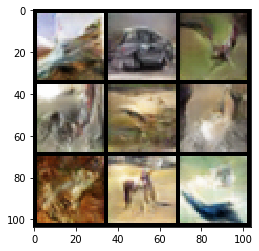

epoch = 86/101, d_loss=0.195, g_loss=4.822                                                                                                     


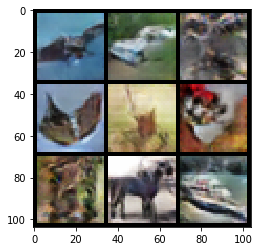

epoch = 87/101, d_loss=0.447, g_loss=5.049                                                                                                     


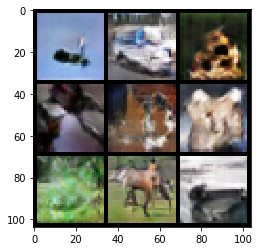

epoch = 88/101, d_loss=0.435, g_loss=3.541                                                                                                     


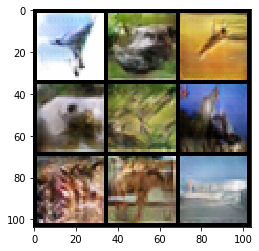

epoch = 89/101, d_loss=0.186, g_loss=8.044                                                                                                     


epoch = 90/101, d_loss=0.202, g_loss=1.337                                                                                                     


epoch = 91/101, d_loss=0.669, g_loss=1.250                                                                                                     


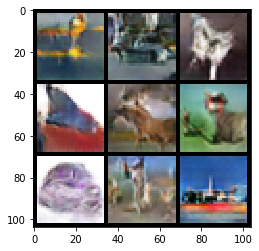

epoch = 92/101, d_loss=0.337, g_loss=3.316                                                                                                     


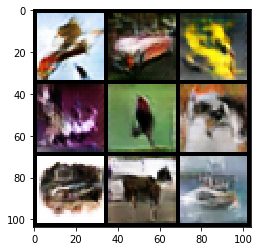

epoch = 93/101, d_loss=0.180, g_loss=7.586                                                                                                     


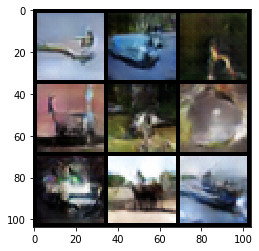

epoch = 94/101, d_loss=0.240, g_loss=3.708                                                                                                     


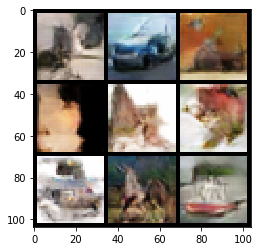

epoch = 95/101, d_loss=0.185, g_loss=3.483                                                                                                     


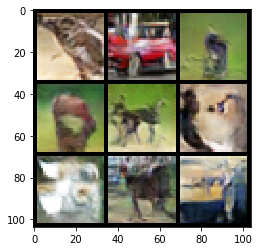

epoch = 96/101, d_loss=0.182, g_loss=8.031                                                                                                     


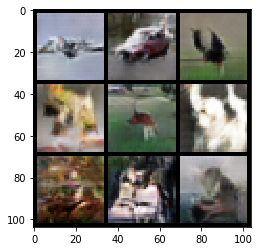

epoch = 97/101, d_loss=0.351, g_loss=4.348                                                                                                     


epoch = 98/101, d_loss=0.169, g_loss=7.236                                                                                                     


epoch = 99/101, d_loss=0.223, g_loss=2.386                                                                                                     


epoch = 100/101, d_loss=0.196, g_loss=8.852                                                                                                     


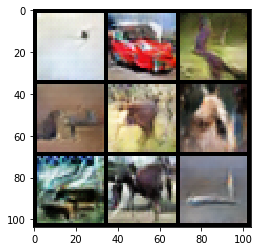

epoch = 101/101, d_loss=0.266, g_loss=6.345                                                                                                     


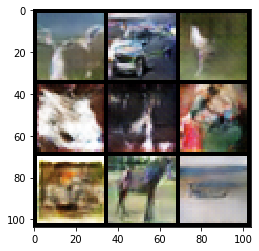

5242.972964525223


In [17]:
start_time = time.time()
d_loss_tot = []
g_loss_tot = []
for epoch in range(num_epochs):
    #print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):

        real_images = Variable(images).cuda()

        real_labels = Variable(torch.LongTensor(to_categorical(labels, num_classes))).cuda()

        fake_labels = np.random.randint(0, 10, len(real_images))
        fake_labels = to_categorical(fake_labels, num_classes)
        fake_labels = Variable(torch.LongTensor(fake_labels)).cuda()

        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, real_labels, fake_labels)    

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, fake_labels)

    generator.eval()
    #print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    d_loss_tot.append(d_loss)
    g_loss_tot.append(g_loss)
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, num_epochs, d_loss, g_loss), 100*' ')
    #if epoch % 10 == 0:
    noise = Variable(torch.FloatTensor(torch.randn(9, nz, 1, 1, requires_grad=False))).cuda()
    random_labels = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8], num_classes)
    random_labels = Variable(torch.LongTensor(random_labels)).cuda()
    sample_images = generator(noise, 9, random_labels).cpu().data
    sample_images = sample_images.view(sample_images.size(0), 3, 32, 32)
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
elapsed_time = time.time() - start_time
print(elapsed_time)

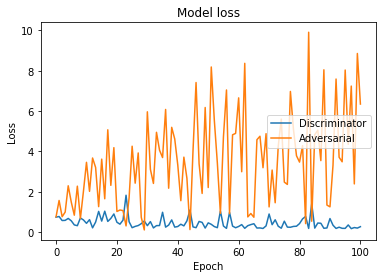

In [18]:
# plotting the metrics
plt.plot(d_loss_tot)
plt.plot(g_loss_tot)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

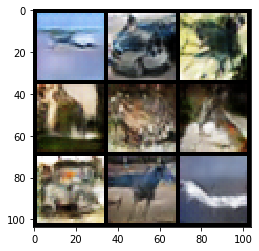

In [43]:
generator.eval()
noise = Variable(torch.FloatTensor(torch.randn(9, nz, 1, 1, requires_grad=False))).cuda()
random_labels = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8], num_classes)
random_labels = Variable(torch.LongTensor(random_labels)).cuda()
sample_images = generator(noise, 9, random_labels).cpu().data
sample_images = sample_images.view(sample_images.size(0), 3, 32, 32)
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()